In [2]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# print(os.getcwd())
# Load the file
df = pd.read_csv("../Gen_data/actual_PV_2022-2024.csv")
# Check the first few rows
print(df.dtypes)
df.head()

datetime             object
Area                 object
Production Type      object
Generation (MWh)    float64
dtype: object


,datetime,Area,Production Type,Generation (MWh)
0,2022-01-01 00:00:00,BZN|ES,Solar,75.0
1,2022-01-01 01:00:00,BZN|ES,Solar,75.0
2,2022-01-01 02:00:00,BZN|ES,Solar,75.0
3,2022-01-01 03:00:00,BZN|ES,Solar,75.0
4,2022-01-01 04:00:00,BZN|ES,Solar,75.0


In [3]:
df = pd.read_csv("../Gen_data/actual_PV_2022-2024.csv")

# Convert datetime column to proper datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Rename the generation column
df['generation'] = df['Generation (MWh)']

# Keep only the necessary columns
df = df[['datetime', 'generation']].sort_values('datetime')

print(df.dtypes)
print(df.head())
print(f"\nData range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"Total records: {len(df)}")

datetime      datetime64[ns]
generation           float64
dtype: object
             datetime  generation
0 2022-01-01 00:00:00        75.0
1 2022-01-01 01:00:00        75.0
2 2022-01-01 02:00:00        75.0
3 2022-01-01 03:00:00        75.0
4 2022-01-01 04:00:00        75.0

Data range: 2022-01-01 00:00:00 to 2024-12-31 23:00:00
Total records: 26301


In [4]:
# Data quality check and outlier detection
print("Data Quality Analysis:")
print("=" * 60)

# Check for missing values
missing_count = df['generation'].isna().sum()
print(f"Missing values: {missing_count}")

# Check for negative values (shouldn't exist for solar generation)
negative_count = (df['generation'] < 0).sum()
print(f"Negative values: {negative_count}")

# Detect outliers using IQR method
Q1 = df['generation'].quantile(0.25)
Q3 = df['generation'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # 3*IQR for extreme outliers
upper_bound = Q3 + 3 * IQR

outliers = ((df['generation'] < lower_bound) | (df['generation'] > upper_bound)).sum()
print(f"Outliers detected (3*IQR method): {outliers}")

# Show basic statistics
print(f"\nGeneration statistics:")
print(f"  Min: {df['generation'].min():.2f} MWh")
print(f"  Max: {df['generation'].max():.2f} MWh")
print(f"  Mean: {df['generation'].mean():.2f} MWh")
print(f"  Median: {df['generation'].median():.2f} MWh")
print(f"  Std: {df['generation'].std():.2f} MWh")
print(f"  95th percentile: {df['generation'].quantile(0.95):.2f} MWh")
print(f"  99th percentile: {df['generation'].quantile(0.99):.2f} MWh")

# Cap extreme outliers to reasonable maximum
df_cleaned = df.copy()
max_reasonable = df['generation'].quantile(0.99) * 1.1  # 110% of 99th percentile
df_cleaned.loc[df_cleaned['generation'] > max_reasonable, 'generation'] = max_reasonable
df_cleaned.loc[df_cleaned['generation'] < 0, 'generation'] = 0  # Remove any negative values

capped_count = (df['generation'] != df_cleaned['generation']).sum()
print(f"\nCapped {capped_count} extreme values to max: {max_reasonable:.2f} MWh")
print("Data is ready for modeling")

# Update df with cleaned data
df = df_cleaned

Data Quality Analysis:
Missing values: 0
Negative values: 0
Outliers detected (3*IQR method): 0

Generation statistics:
  Min: 0.00 MWh
  Max: 21280.00 MWh
  Mean: 4518.56 MWh
  Median: 711.00 MWh
  Std: 5639.79 MWh
  95th percentile: 15526.00 MWh
  99th percentile: 19172.00 MWh

Capped 5 extreme values to max: 21089.20 MWh
Data is ready for modeling


**Features created. Overall are 35 features**

In [5]:
# Create time-based features for XGBoost - MINIMAL LAG DEPENDENCY
def create_features(df):
    """
    Create features focusing on time and solar patterns, NOT historical values
    This ensures forecasting works properly for future dates
    """
    df = df.copy()
    
    # Basic time features
    df['hour'] = df['datetime'].dt.hour
    df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['dayofyear'] = df['datetime'].dt.dayofyear
    df['weekofyear'] = df['datetime'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['datetime'].dt.quarter
    
    # Cyclical encoding (CRITICAL for time patterns)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    # Solar elevation (MOST IMPORTANT for PV forecasting)
    hour_angle = (df['hour'] - 12) * 15  # degrees from solar noon
    declination = 23.45 * np.sin(2 * np.pi * (df['dayofyear'] - 81) / 365)
    latitude = 45  # Europe
    
    solar_elevation_rad = np.arcsin(
        np.sin(np.radians(latitude)) * np.sin(np.radians(declination)) +
        np.cos(np.radians(latitude)) * np.cos(np.radians(declination)) * 
        np.cos(np.radians(hour_angle))
    )
    df['solar_elevation'] = np.degrees(solar_elevation_rad).clip(lower=0)
    
    # Clear sky irradiance proxy (based on solar elevation)
    df['clearsky_ghi'] = np.where(
        df['solar_elevation'] > 0,
        1000 * (np.sin(np.radians(df['solar_elevation'])) ** 1.2),
        0
    )
    
    # Solar azimuth approximation (sun direction)
    df['solar_azimuth'] = np.where(
        df['hour'] < 12,
        -1 * (12 - df['hour']) / 12,  # Morning: -1 to 0
        (df['hour'] - 12) / 12  # Afternoon: 0 to 1
    )
    
    # Day length (hours of daylight)
    df['day_length'] = 12 + 3.8 * np.sin(2 * np.pi * (df['dayofyear'] - 81) / 365)
    
    # Time of day indicators
    df['is_daylight'] = (df['solar_elevation'] > 0).astype(int)
    df['is_peak_hours'] = ((df['hour'] >= 10) & (df['hour'] <= 16)).astype(int)
    df['is_morning'] = ((df['hour'] >= 6) & (df['hour'] < 12)).astype(int)
    df['is_afternoon'] = ((df['hour'] >= 12) & (df['hour'] <= 18)).astype(int)
    
    # Season indicators
    df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
    df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int)
    df['is_spring'] = df['month'].isin([3, 4, 5]).astype(int)
    df['is_fall'] = df['month'].isin([9, 10, 11]).astype(int)
    
    # Weekend/weekday
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # Interaction features (hour × solar features)
    df['hour_x_elevation'] = df['hour'] * df['solar_elevation']
    df['hour_x_clearsky'] = df['hour'] * df['clearsky_ghi']
    df['month_x_hour'] = df['month'] * df['hour']
    df['dayofyear_x_hour'] = df['dayofyear'] * df['hour']
    
    # Higher order solar features
    df['solar_elevation_sq'] = df['solar_elevation'] ** 2
    df['clearsky_ghi_sq'] = df['clearsky_ghi'] ** 2
    
    return df

# Create features (NO lag features that depend on generation values)
print("Creating features without lag dependency...")
df = create_features(df)

# No need to drop rows since we have no lag features
df_clean = df.copy()

print(f"Total data points: {len(df_clean)}")
print(f"Features created: {len([col for col in df_clean.columns if col not in ['datetime', 'generation']])}")
print(f"\nFeature list:")
print([col for col in df_clean.columns if col not in ['datetime', 'generation']])

# Split data into train (70%), validation (20%), and test (10%)
total_rows = len(df_clean)
train_size = int(0.7 * total_rows)
val_size = int(0.2 * total_rows)

train_df = df_clean.iloc[:train_size].copy()
val_df = df_clean.iloc[train_size:train_size + val_size].copy()
test_df = df_clean.iloc[train_size + val_size:].copy()

print(f"\nTraining set: {len(train_df)} records")
print(f"  Period: {train_df['datetime'].min()} to {train_df['datetime'].max()}")
print(f"\nValidation set: {len(val_df)} records")
print(f"  Period: {val_df['datetime'].min()} to {val_df['datetime'].max()}")
print(f"\nTest set: {len(test_df)} records")
print(f"  Period: {test_df['datetime'].min()} to {test_df['datetime'].max()}")

Creating features without lag dependency...
Total data points: 26301
Features created: 35

Feature list:
['hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'dayofweek_sin', 'dayofweek_cos', 'solar_elevation', 'clearsky_ghi', 'solar_azimuth', 'day_length', 'is_daylight', 'is_peak_hours', 'is_morning', 'is_afternoon', 'is_summer', 'is_winter', 'is_spring', 'is_fall', 'is_weekend', 'hour_x_elevation', 'hour_x_clearsky', 'month_x_hour', 'dayofyear_x_hour', 'solar_elevation_sq', 'clearsky_ghi_sq']

Training set: 18410 records
  Period: 2022-01-01 00:00:00 to 2024-02-07 03:00:00

Validation set: 5260 records
  Period: 2024-02-07 04:00:00 to 2024-09-13 08:00:00

Test set: 2631 records
  Period: 2024-09-13 09:00:00 to 2024-12-31 23:00:00


**Prepare features and target for XGboost**

* x_train is the column of "feature_cols" extracted from train_df.
* y_train is the predicted value of power generation.

In [6]:
# Prepare features and target for XGBoost
feature_cols = [col for col in train_df.columns if col not in ['datetime', 'generation']]

X_train = train_df[feature_cols]
y_train = train_df['generation']

X_val = val_df[feature_cols]
y_val = val_df['generation']

X_test = test_df[feature_cols]
y_test = test_df['generation']

print(f"Features used: {len(feature_cols)}")
print(f"Sample features: {feature_cols[:15]}")

# Create XGBoost model optimized for solar forecasting
# Key changes: deeper trees, higher learning rate, less regularization
model = xgb.XGBRegressor(
    n_estimators=8000,              # More trees
    max_depth=12,                   # Deeper trees to capture complex patterns
    learning_rate=0.05,             # Balanced learning rate
    subsample=0.9,                  # Higher subsample ratio
    colsample_bytree=0.9,           # Higher feature sampling
    colsample_bylevel=0.9,          
    min_child_weight=1,             # Allow more splits
    gamma=0,                        # No minimum loss reduction (allow all beneficial splits)
    reg_alpha=0,                    # Remove L1 regularization
    reg_lambda=0.5,                 # Reduce L2 regularization
    random_state=42,
    n_jobs=-1,
    tree_method='hist',             
    early_stopping_rounds=150,      
    eval_metric='rmse',
    max_bin=512                     # More bins for better split finding
)

print("\nTraining XGBoost model optimized for daytime solar prediction...")
print("=" * 60)
print("Model Configuration:")
print(f"  - n_estimators: {model.n_estimators}")
print(f"  - max_depth: {model.max_depth}")
print(f"  - learning_rate: {model.learning_rate}")
print(f"  - subsample: {model.subsample}")
print(f"  - colsample_bytree: {model.colsample_bytree}")
print(f"  - gamma: {model.gamma}")
print(f"  - reg_lambda: {model.reg_lambda}")
print("=" * 60)

# Train the model with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

print("\nTraining complete!")
print(f"Best iteration: {model.best_iteration}")
print(f"Best validation RMSE: {model.best_score:.4f}")

# Check the scale of predictions vs actuals
train_pred_sample = model.predict(X_train[:1000])
print(f"\nSanity check on training data (first 1000 samples):")
print(f"  Actual range: {y_train[:1000].min():.2f} - {y_train[:1000].max():.2f} MWh")
print(f"  Predicted range: {train_pred_sample.min():.2f} - {train_pred_sample.max():.2f} MWh")

Features used: 35
Sample features: ['hour', 'day', 'month', 'year', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'dayofweek_sin']

Training XGBoost model optimized for daytime solar prediction...
Model Configuration:
  - n_estimators: 8000
  - max_depth: 12
  - learning_rate: 0.05
  - subsample: 0.9
  - colsample_bytree: 0.9
  - gamma: 0
  - reg_lambda: 0.5
[0]	validation_0-rmse:4787.86106	validation_1-rmse:7297.92213
[100]	validation_0-rmse:177.11936	validation_1-rmse:2658.92542
[200]	validation_0-rmse:90.41568	validation_1-rmse:2653.38241
[295]	validation_0-rmse:59.88570	validation_1-rmse:2660.33240

Training complete!
Best iteration: 145
Best validation RMSE: 2650.0707

Sanity check on training data (first 1000 samples):
  Actual range: 0.00 - 10253.00 MWh
  Predicted range: 17.09 - 10187.25 MWh


Top 20 Most Important Features:
             feature  importance
20       is_daylight    0.324283
29  hour_x_elevation    0.192494
23      is_afternoon    0.145641
21     is_peak_hours    0.100555
30   hour_x_clearsky    0.083499
7            quarter    0.036925
24         is_summer    0.018072
11         month_cos    0.012765
25         is_winter    0.012345
13     dayofyear_cos    0.009310
8           hour_sin    0.009239
3               year    0.006010
19        day_length    0.005846
31      month_x_hour    0.003717
18     solar_azimuth    0.003606
12     dayofyear_sin    0.003427
2              month    0.002949
27           is_fall    0.002883
0               hour    0.002851
10         month_sin    0.002782


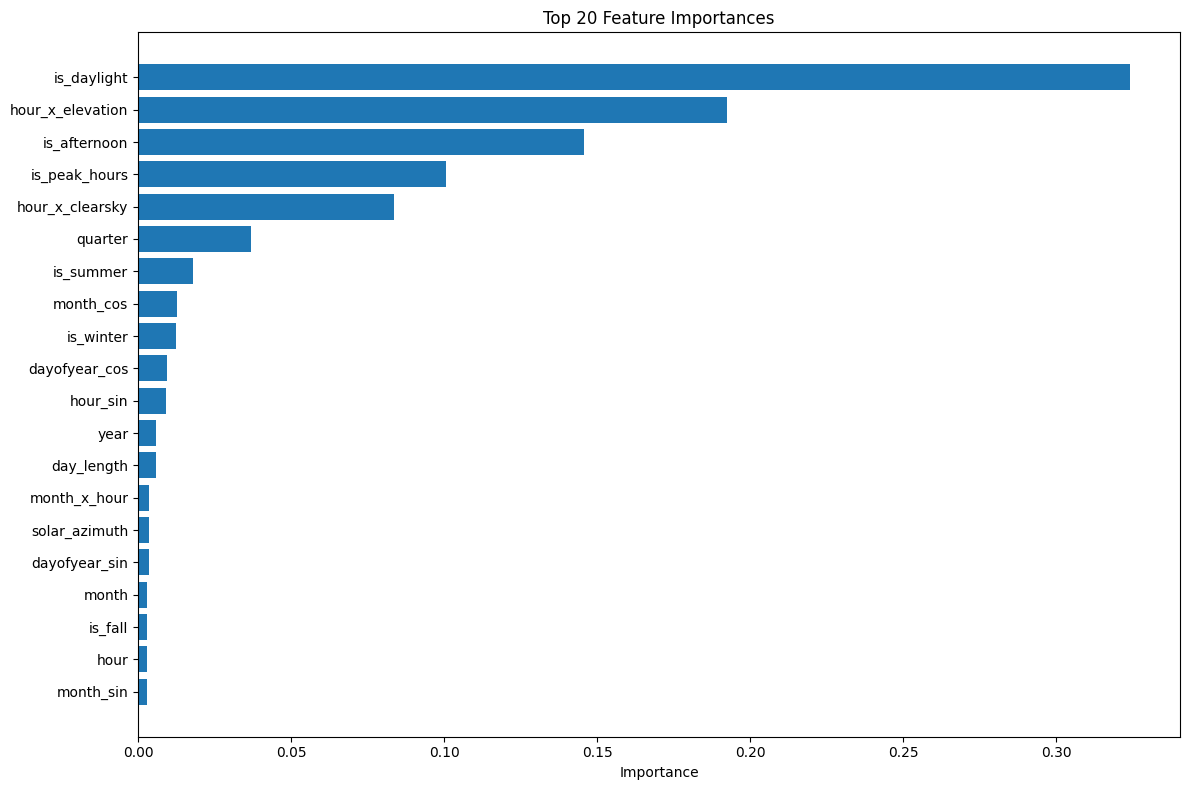

In [7]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print("=" * 50)
print(feature_importance.head(20).to_string())

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [8]:
# Validate model on validation set
val_pred = model.predict(X_val)

# Clip predictions to non-negative values
val_pred = np.clip(val_pred, 0, None)

# Calculate validation metrics
val_mae = mean_absolute_error(y_val, val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

# Calculate MAPE excluding very small values (< 10 MWh threshold)
threshold = 10  # MWh
significant_mask = y_val >= threshold
if significant_mask.sum() > 0:
    val_mape = np.mean(np.abs((y_val[significant_mask] - val_pred[significant_mask]) / y_val[significant_mask])) * 100
else:
    val_mape = np.nan

print("Validation Set Performance:")
print("=" * 50)
print(f"MAE:  {val_mae:.2f} MWh")
print(f"RMSE: {val_rmse:.2f} MWh")
if not np.isnan(val_mape):
    print(f"MAPE (generation >= {threshold} MWh): {val_mape:.2f}%")
else:
    print(f"MAPE: N/A")
    
# Show additional info
zero_count = (y_val == 0).sum()
low_gen_count = ((y_val > 0) & (y_val < threshold)).sum()
print(f"\nData distribution in validation set:")
print(f"  Zero values: {zero_count} ({zero_count/len(y_val)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh): {low_gen_count} ({low_gen_count/len(y_val)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh): {significant_mask.sum()} ({significant_mask.sum()/len(y_val)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range:")
print(f"  Min: {val_pred.min():.2f} MWh")
print(f"  Max: {val_pred.max():.2f} MWh")
print(f"  Mean: {val_pred.mean():.2f} MWh")

Validation Set Performance:
MAE:  1615.07 MWh
RMSE: 2650.07 MWh
MAPE (generation >= 10 MWh): 92.87%

Data distribution in validation set:
  Zero values: 0 (0.0%)
  Low generation (0-10 MWh): 5 (0.1%)
  Significant generation (>=10 MWh): 5255 (99.9%)

Prediction range:
  Min: 16.83 MWh
  Max: 17208.95 MWh
  Mean: 5679.62 MWh


In [9]:
# Test model on test set
test_pred = model.predict(X_test)

# Clip predictions to non-negative values
test_pred = np.clip(test_pred, 0, None)

# Calculate test metrics
test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

# Calculate MAPE excluding very small values (< 10 MWh threshold)
threshold = 10  # MWh
significant_mask = y_test >= threshold
if significant_mask.sum() > 0:
    test_mape = np.mean(np.abs((y_test[significant_mask] - test_pred[significant_mask]) / y_test[significant_mask])) * 100
else:
    test_mape = np.nan

print("Test Set Performance:")
print("=" * 50)
print(f"MAE:  {test_mae:.2f} MWh")
print(f"RMSE: {test_rmse:.2f} MWh")
if not np.isnan(test_mape):
    print(f"MAPE (generation >= {threshold} MWh): {test_mape:.2f}%")
else:
    print(f"MAPE: N/A")
    
# Show additional info
zero_count = (y_test == 0).sum()
low_gen_count = ((y_test > 0) & (y_test < threshold)).sum()
print(f"\nData distribution in test set:")
print(f"  Zero values: {zero_count} ({zero_count/len(y_test)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh): {low_gen_count} ({low_gen_count/len(y_test)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh): {significant_mask.sum()} ({significant_mask.sum()/len(y_test)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range:")
print(f"  Min: {test_pred.min():.2f} MWh")
print(f"  Max: {test_pred.max():.2f} MWh")
print(f"  Mean: {test_pred.mean():.2f} MWh")

Test Set Performance:
MAE:  1218.20 MWh
RMSE: 2302.37 MWh
MAPE (generation >= 10 MWh): 63.07%

Data distribution in test set:
  Zero values: 0 (0.0%)
  Low generation (0-10 MWh): 22 (0.8%)
  Significant generation (>=10 MWh): 2609 (99.2%)

Prediction range:
  Min: 0.00 MWh
  Max: 15403.37 MWh
  Mean: 3375.90 MWh


In [10]:
# Diagnostic: Analyze error distribution on validation set
val_df_analysis = val_df.copy()
val_df_analysis['predicted'] = val_pred
val_df_analysis['error'] = y_val.values - val_pred
val_df_analysis['abs_error'] = np.abs(val_df_analysis['error'])
val_df_analysis['pct_error'] = np.where(
    y_val.values >= 10, 
    np.abs(val_df_analysis['error'] / y_val.values) * 100,
    np.nan
)

print("Error Analysis on Validation Set:")
print("=" * 50)
print(f"\nActual generation statistics:")
print(val_df_analysis['generation'].describe())

print(f"\nPredicted generation statistics:")
print(pd.Series(val_pred).describe())

print(f"\nAbsolute error statistics:")
print(val_df_analysis['abs_error'].describe())

print(f"\nPercentage error statistics (excluding low generation):")
print(val_df_analysis['pct_error'].describe())

# Show some examples of high errors
print(f"\n5 Largest absolute errors:")
print(val_df_analysis.nlargest(5, 'abs_error')[['datetime', 'generation', 'predicted', 'error', 'pct_error']])

Error Analysis on Validation Set:

Actual generation statistics:
count     5260.000000
mean      6583.207034
std       7143.369119
min          4.000000
25%        436.750000
50%       2146.500000
75%      13519.250000
max      21089.200000
Name: generation, dtype: float64

Predicted generation statistics:
count     5260.000000
mean      5679.624512
std       5992.760254
min         16.834652
25%        397.497612
50%       1896.822571
75%      11934.294678
max      17208.949219
dtype: float64

Absolute error statistics:
count     5260.000000
mean      1615.068204
std       2101.254141
min          0.157776
25%        130.702412
50%        467.902206
75%       2661.996338
max      11304.199219
Name: abs_error, dtype: float64

Percentage error statistics (excluding low generation):
count    5255.000000
mean       92.873615
std       279.946173
min         0.018460
25%        13.679250
50%        26.622895
75%        56.973791
max      6510.847024
Name: pct_error, dtype: float64

5 Large

In [11]:
# Create forecast for 2025 (January to October)
print("Forecasting for 2025 (January to October)...")
print("=" * 60)

# Create future dates for Jan-Oct 2025
future_dates = pd.date_range(start='2025-01-01 00:00:00', end='2025-10-31 23:00:00', freq='1H')
future_df = pd.DataFrame({'datetime': future_dates})

print(f"Forecast period: {future_df['datetime'].min()} to {future_df['datetime'].max()}")
print(f"Total hours to forecast: {len(future_df)}")

# Create features for 2025 (NO generation column needed - no lag features!)
future_features = create_features(future_df)

# Prepare features for prediction
feature_cols_check = [col for col in feature_cols if col in future_features.columns]
print(f"\nFeatures available: {len(feature_cols_check)}/{len(feature_cols)}")

if len(feature_cols_check) != len(feature_cols):
    missing = set(feature_cols) - set(feature_cols_check)
    print(f"Missing features: {missing}")

X_future = future_features[feature_cols].copy()

# Check for any NaN values
nan_count = X_future.isna().sum().sum()
if nan_count > 0:
    print(f"WARNING: {nan_count} NaN values found")
    print("Filling NaN with 0...")
    X_future = X_future.fillna(0)
else:
    print("No NaN values - ready for prediction!")

# Make predictions
print("\nGenerating 2025 forecasts...")
forecast_values = model.predict(X_future)

# Clip negative values
forecast_values = np.clip(forecast_values, 0, None)

# Create forecast dataframe
forecast_2025 = pd.DataFrame({
    'datetime': future_dates,
    'yhat': forecast_values
})

# Add hour for analysis
forecast_2025['hour'] = forecast_2025['datetime'].dt.hour
forecast_2025['month'] = forecast_2025['datetime'].dt.month

print("\n" + "=" * 60)
print("FORECAST COMPLETE")
print("=" * 60)
print(f"Total predictions: {len(forecast_2025)}")
print(f"\nForecast statistics:")
print(f"  Min:  {forecast_2025['yhat'].min():.2f} MWh")
print(f"  Max:  {forecast_2025['yhat'].max():.2f} MWh")
print(f"  Mean: {forecast_2025['yhat'].mean():.2f} MWh")
print(f"  Median: {forecast_2025['yhat'].median():.2f} MWh")

# Check hourly pattern
print(f"\nAverage forecast by hour (daylight hours 6-18):")
hourly_avg = forecast_2025.groupby('hour')['yhat'].mean()
for h in range(6, 19):
    print(f"  Hour {h:02d}: {hourly_avg[h]:>8.2f} MWh")

# Check monthly pattern
print(f"\nAverage forecast by month:")
monthly_avg = forecast_2025.groupby('month')['yhat'].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
for i, month in enumerate(range(1, 11), 1):
    print(f"  {month_names[i-1]}: {monthly_avg[month]:>8.2f} MWh")

Forecasting for 2025 (January to October)...
Forecast period: 2025-01-01 00:00:00 to 2025-10-31 23:00:00
Total hours to forecast: 7296

Features available: 35/35
No NaN values - ready for prediction!

Generating 2025 forecasts...

FORECAST COMPLETE
Total predictions: 7296

Forecast statistics:
  Min:  17.75 MWh
  Max:  17296.66 MWh
  Mean: 5092.83 MWh
  Median: 978.92 MWh

Average forecast by hour (daylight hours 6-18):
  Hour 06:   165.29 MWh
  Hour 07:   234.53 MWh
  Hour 08:  1675.32 MWh
  Hour 09:  5700.99 MWh
  Hour 10:  9837.32 MWh
  Hour 11: 11957.72 MWh
  Hour 12: 12792.21 MWh
  Hour 13: 13053.29 MWh
  Hour 14: 13052.78 MWh
  Hour 15: 12802.35 MWh
  Hour 16: 12051.18 MWh
  Hour 17: 10388.44 MWh
  Hour 18:  7942.17 MWh

Average forecast by month:
  Jan:  2565.26 MWh
  Feb:  3724.86 MWh
  Mar:  4523.29 MWh
  Apr:  5891.51 MWh
  May:  5669.69 MWh
  Jun:  6002.25 MWh
  Jul:  7002.74 MWh
  Aug:  6719.31 MWh
  Sep:  5104.31 MWh
  Oct:  3648.14 MWh


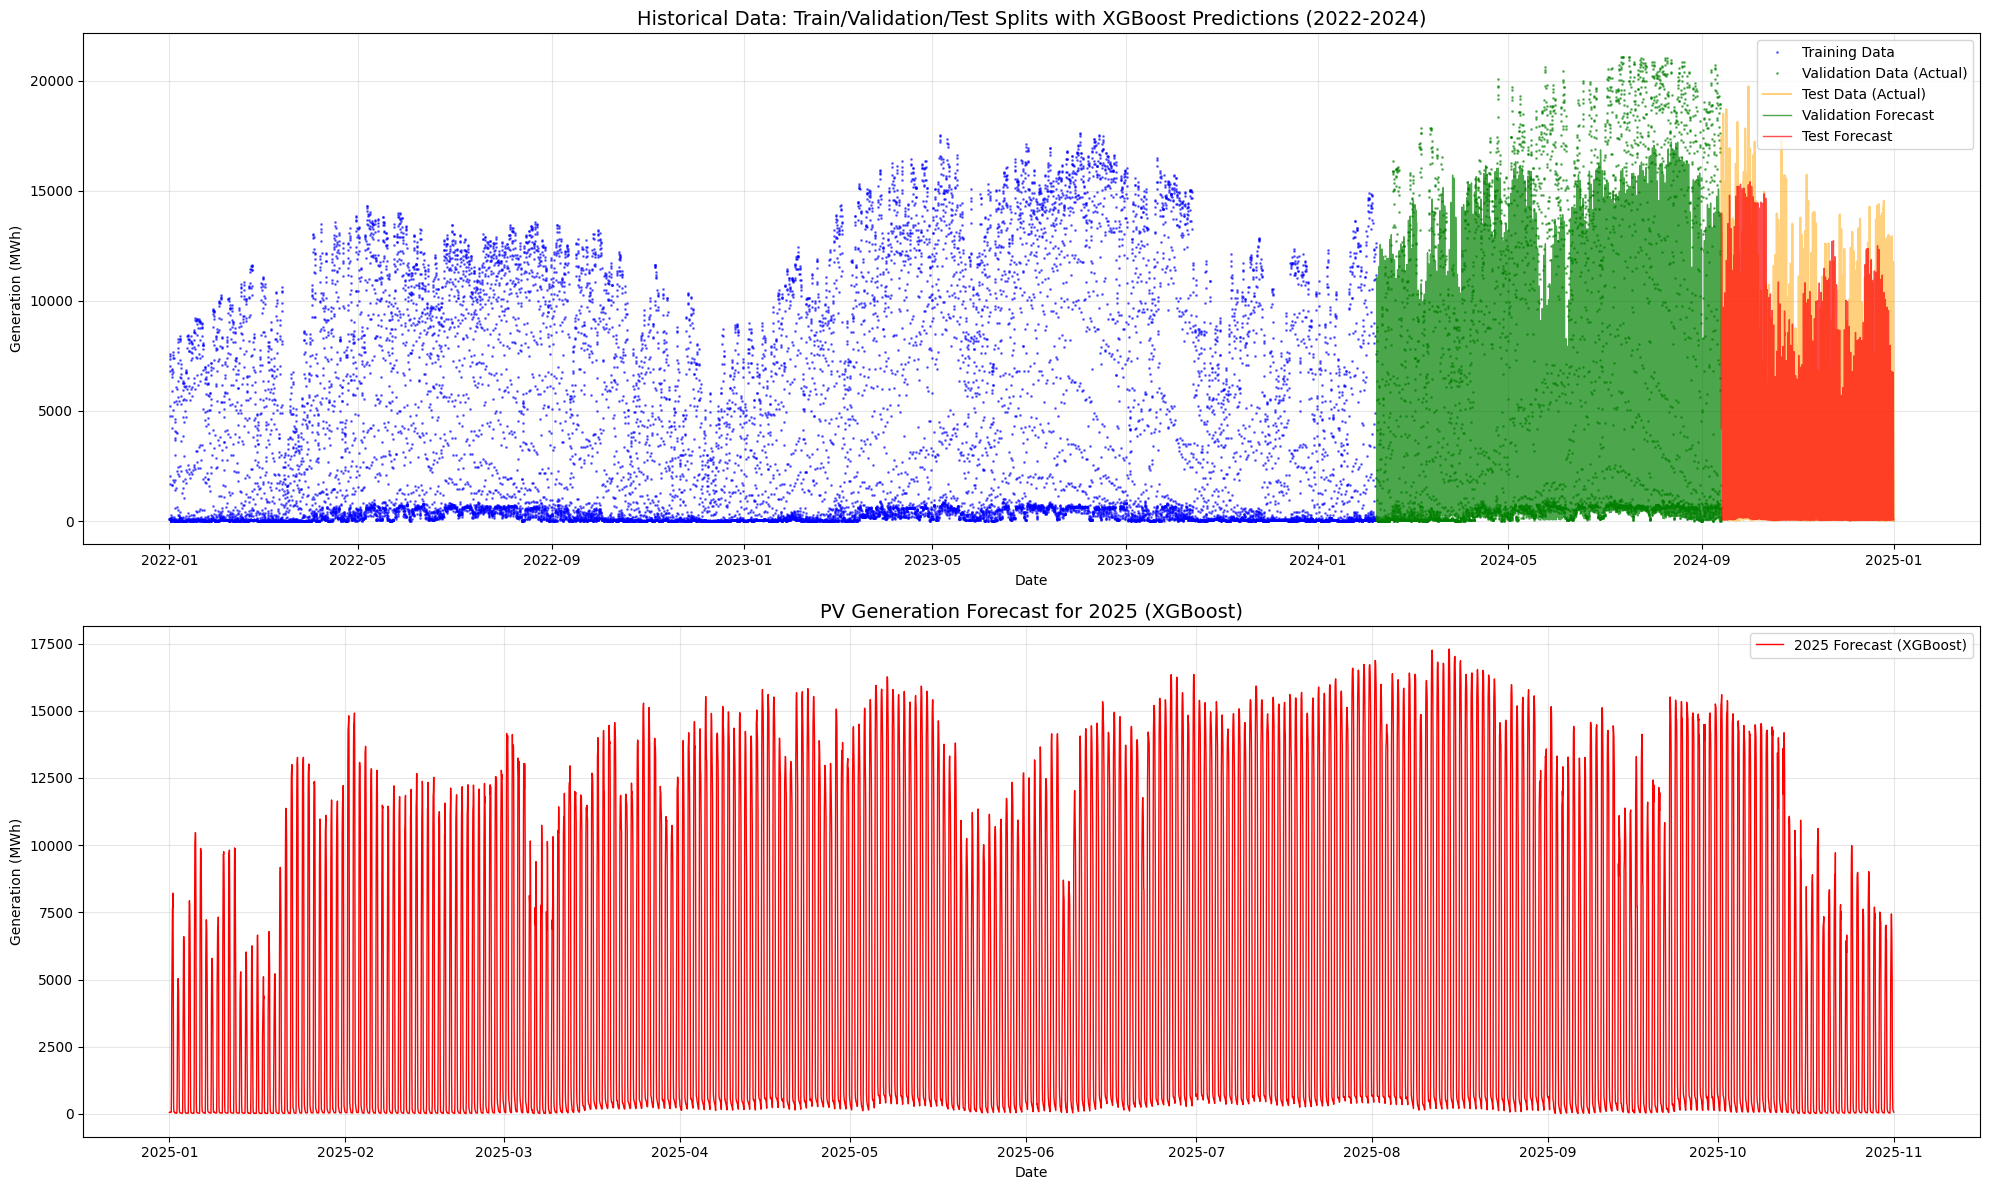

In [12]:
# Visualize train/val/test splits and model performance
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Plot 1: Historical data with splits
ax1 = axes[0]
ax1.plot(train_df['datetime'], train_df['generation'], 'b.', label='Training Data', alpha=0.5, markersize=2)
ax1.plot(val_df['datetime'], val_df['generation'], 'g.', label='Validation Data (Actual)', alpha=0.5, markersize=2)
ax1.plot(test_df['datetime'], test_df['generation'], 'orange', label='Test Data (Actual)', alpha=0.5, markersize=2)

# Add predictions on validation and test sets
ax1.plot(val_df['datetime'].values, val_pred, 'g-', label='Validation Forecast', linewidth=1, alpha=0.7)
ax1.plot(test_df['datetime'].values, test_pred, 'r-', label='Test Forecast', linewidth=1, alpha=0.7)

ax1.set_title('Historical Data: Train/Validation/Test Splits with XGBoost Predictions (2022-2024)', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Generation (MWh)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: 2025 Forecast
ax2 = axes[1]
ax2.plot(forecast_2025['datetime'], forecast_2025['yhat'], 'r-', label='2025 Forecast (XGBoost)', linewidth=1)

ax2.set_title('PV Generation Forecast for 2025 (XGBoost)', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Generation (MWh)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

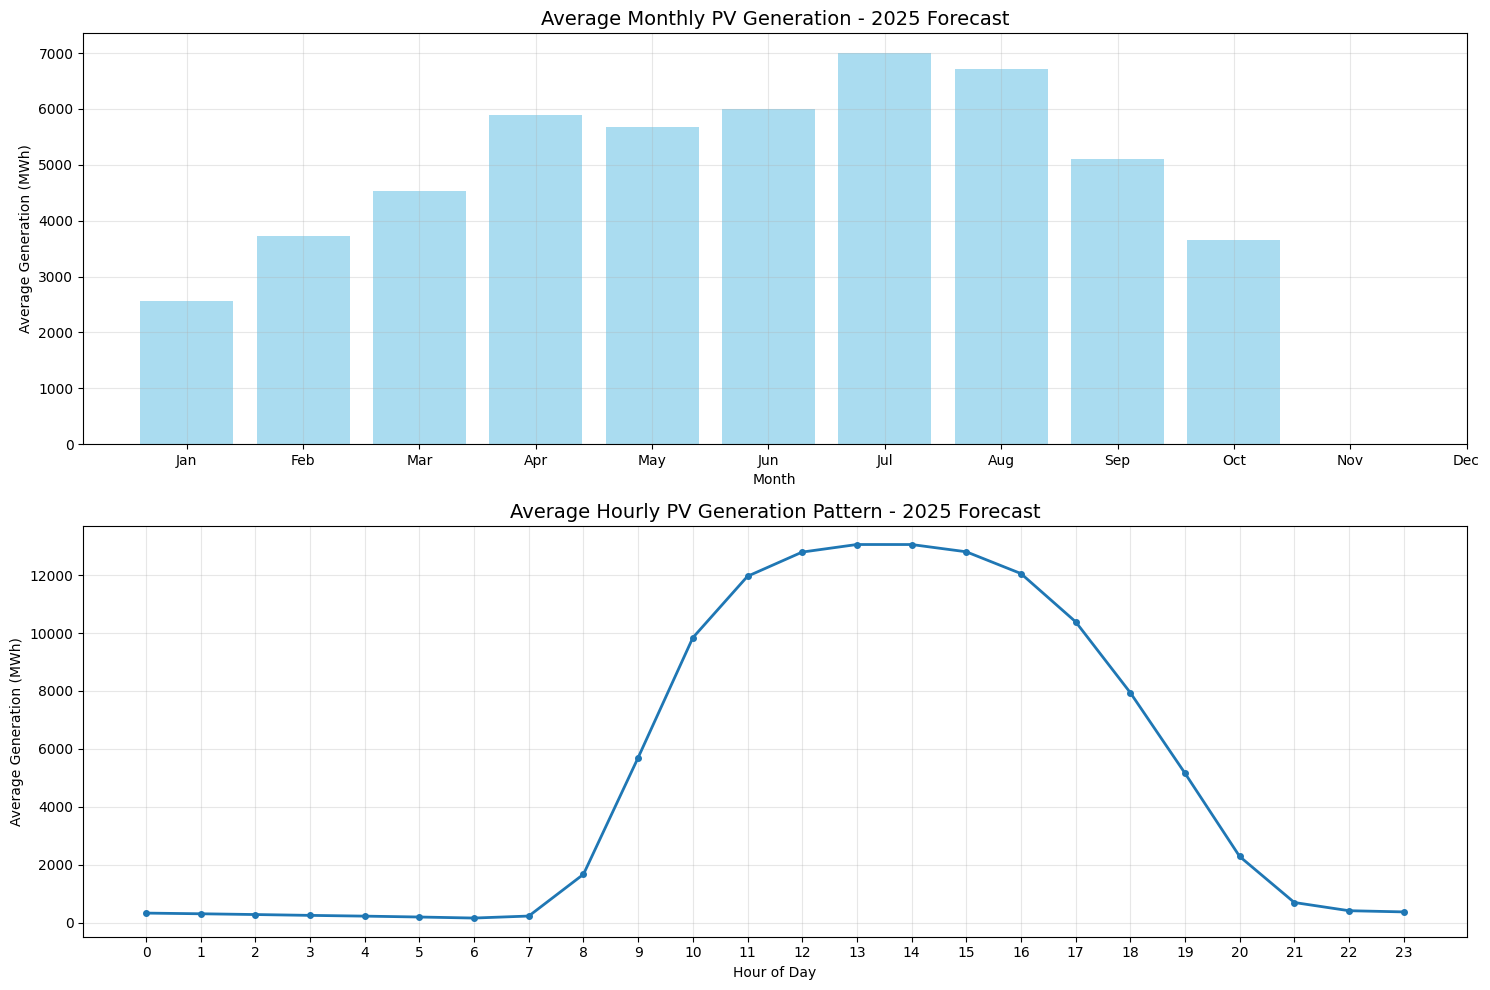

Monthly Generation Summary:
Jan: 2565.26 MWh
Feb: 3724.86 MWh
Mar: 4523.29 MWh
Apr: 5891.51 MWh
May: 5669.69 MWh
Jun: 6002.25 MWh
Jul: 7002.74 MWh
Aug: 6719.31 MWh
Sep: 5104.31 MWh
Oct: 3648.14 MWh


In [13]:
# Analyze seasonal patterns in the forecast
forecast_2025['month'] = forecast_2025['datetime'].dt.month
forecast_2025['hour'] = forecast_2025['datetime'].dt.hour

# Monthly average generation
monthly_avg = forecast_2025.groupby('month')['yhat'].mean()

# Hourly average generation
hourly_avg = forecast_2025.groupby('hour')['yhat'].mean()

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot monthly pattern
ax1 = axes[0]
ax1.bar(monthly_avg.index, monthly_avg.values, alpha=0.7, color='skyblue')
ax1.set_title('Average Monthly PV Generation - 2025 Forecast', fontsize=14)
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Generation (MWh)')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax1.grid(True, alpha=0.3)

# Plot hourly pattern
ax2 = axes[1]
ax2.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=4)
ax2.set_title('Average Hourly PV Generation Pattern - 2025 Forecast', fontsize=14)
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Average Generation (MWh)')
ax2.set_xticks(range(0, 24))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Monthly Generation Summary:")
print("=" * 50)
for month, value in monthly_avg.items():
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    print(f"{month_names[month-1]}: {value:.2f} MWh")

In [14]:
# Export 2025 forecast to CSV
forecast_export = forecast_2025[['datetime', 'yhat']].copy()
forecast_export['timestamp'] = forecast_export['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')
forecast_export = forecast_export[['timestamp', 'yhat']].rename(columns={
    'timestamp': 'Timestamp',
    'yhat': 'Forecast_Generation_MWh'
})

output_file = 'pv_forecast_2025_hourly_xgboost.csv'
forecast_export.to_csv(output_file, index=False)
print(f"2025 forecast exported to: {output_file}")
print(f"\nSummary statistics of 2025 forecast:")
print(forecast_export.describe())

2025 forecast exported to: pv_forecast_2025_hourly_xgboost.csv

Summary statistics of 2025 forecast:
       Forecast_Generation_MWh
count              7296.000000
mean               5092.827637
std                5762.181152
min                  17.752678
25%                 258.963669
50%                 978.922668
75%               10946.180664
max               17296.662109


In [15]:
# Load actual 2025 data for comparison
df_2025 = pd.read_csv("../Gen_data/actual_PV_2025.csv")
df_2025

,datetime,Area,Production Type,Generation (MWh)
0,2025-01-01 00:00:00,BZN|ES,Solar,4.000000
1,2025-01-01 01:00:00,BZN|ES,Solar,4.000000
2,2025-01-01 02:00:00,BZN|ES,Solar,4.000000
3,2025-01-01 03:00:00,BZN|ES,Solar,4.000000
4,2025-01-01 04:00:00,BZN|ES,Solar,4.000000
...,...,...,...,...
7047,2025-10-21 16:00:00,BZN|ES,Solar,11324.000000
7048,2025-10-21 17:00:00,BZN|ES,Solar,8866.000000
7049,2025-10-21 18:00:00,BZN|ES,Solar,4370.000000
7050,2025-10-21 19:00:00,BZN|ES,Solar,688.000000


In [16]:
# Load actual 2025 data and prepare for comparison
df_2025_actual = pd.read_csv("../Gen_data/actual_PV_2025.csv")
df_2025_actual['datetime'] = pd.to_datetime(df_2025_actual['datetime'])
df_2025_actual['generation'] = df_2025_actual['Generation (MWh)']
df_2025_actual = df_2025_actual[['datetime', 'generation']].sort_values('datetime')

print(f"2025 actual data loaded:")
print(f"  Period: {df_2025_actual['datetime'].min()} to {df_2025_actual['datetime'].max()}")
print(f"  Total records: {len(df_2025_actual)}")
print(f"  Data range: {df_2025_actual['generation'].min():.2f} to {df_2025_actual['generation'].max():.2f} MWh")

# Merge forecast with actual 2025 data
comparison = pd.merge(
    forecast_2025[['datetime', 'yhat']], 
    df_2025_actual[['datetime', 'generation']], 
    on='datetime', 
    how='inner'
)

print(f"\nMatched records: {len(comparison)}")

# Calculate metrics
mae = mean_absolute_error(comparison['generation'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['generation'], comparison['yhat']))

# Calculate MAPE excluding very small values
threshold = 10  # MWh
significant_mask = comparison['generation'] >= threshold
if significant_mask.sum() > 0:
    mape = np.mean(np.abs((comparison['generation'][significant_mask] - comparison['yhat'][significant_mask]) / comparison['generation'][significant_mask])) * 100
else:
    mape = np.nan

print(f"\n2025 Forecast Performance Metrics (XGBoost):")
print("=" * 50)
print(f"MAE:  {mae:.2f} MWh")
print(f"RMSE: {rmse:.2f} MWh")
if not np.isnan(mape):
    print(f"MAPE (generation >= {threshold} MWh): {mape:.2f}%")
else:
    print(f"MAPE: N/A")

# Show data ranges
print(f"\nData ranges:")
print(f"  Actual values: {comparison['generation'].min():.2f} to {comparison['generation'].max():.2f} MWh")
print(f"  Forecasted values: {comparison['yhat'].min():.2f} to {comparison['yhat'].max():.2f} MWh")

2025 actual data loaded:
  Period: 2025-01-01 00:00:00 to 2025-10-21 20:00:00
  Total records: 7052
  Data range: 0.00 to 23999.00 MWh

Matched records: 7052

2025 Forecast Performance Metrics (XGBoost):
MAE:  1965.12 MWh
RMSE: 3277.57 MWh
MAPE (generation >= 10 MWh): 68.65%

Data ranges:
  Actual values: 0.00 to 23999.00 MWh
  Forecasted values: 17.75 to 17296.66 MWh


In [17]:
# Detailed analysis of 2025 forecast performance
# Check for zero values in actual data
zero_counts = (comparison['generation'] == 0).sum()
print(f"Number of zero values in actual data: {zero_counts}")

# Calculate metrics with handling for zero values
mae = mean_absolute_error(comparison['generation'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['generation'], comparison['yhat']))

# Modified MAPE calculation excluding zero values
non_zero_mask = comparison['generation'] != 0
if non_zero_mask.sum() > 0:
    mape = np.mean(np.abs((comparison['generation'][non_zero_mask] - comparison['yhat'][non_zero_mask]) / comparison['generation'][non_zero_mask])) * 100
else:
    mape = np.nan

print(f"\nMetrics (excluding zero values for MAPE):")
print(f"Mean Absolute Error (MAE): {mae:.2f} MWh")
if not np.isnan(mape):
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
else:
    print(f"MAPE: N/A")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} MWh")

# R² Score
from sklearn.metrics import r2_score
r2 = r2_score(comparison['generation'], comparison['yhat'])
print(f"R² Score: {r2:.4f}")

# Show min/max values
print(f"\nData ranges:")
print(f"Actual values range: {comparison['generation'].min():.2f} to {comparison['generation'].max():.2f} MWh")
print(f"Forecasted values range: {comparison['yhat'].min():.2f} to {comparison['yhat'].max():.2f} MWh")

Number of zero values in actual data: 2

Metrics (excluding zero values for MAPE):
Mean Absolute Error (MAE): 1965.12 MWh
Mean Absolute Percentage Error (MAPE): 77.98%
Root Mean Square Error (RMSE): 3277.57 MWh
R² Score: 0.8071

Data ranges:
Actual values range: 0.00 to 23999.00 MWh
Forecasted values range: 17.75 to 17296.66 MWh


In [18]:
# Add hour of day for filtering daylight hours
comparison['hour'] = comparison['datetime'].dt.hour

# Filter for daylight hours (e.g., between 6 AM and 8 PM)
daylight_mask = (comparison['hour'] >= 6) & (comparison['hour'] <= 20)
daylight_data = comparison[daylight_mask]

# Calculate installed capacity (using 95th percentile of actual values as proxy)
installed_capacity = comparison['generation'].quantile(0.95)

# Calculate metrics for daylight hours only
daylight_mae = mean_absolute_error(daylight_data['generation'], daylight_data['yhat'])
daylight_rmse = np.sqrt(mean_squared_error(daylight_data['generation'], daylight_data['yhat']))
nmae = daylight_mae / installed_capacity * 100
nrmse = daylight_rmse / installed_capacity * 100

# Calculate skill score using persistence model (previous day as forecast)
persistence_forecast = daylight_data['generation'].shift(24)  # Shift by 1 day (24 hours)
valid_indices = ~persistence_forecast.isna()
if valid_indices.sum() > 0:
    persistence_mse = mean_squared_error(
        daylight_data['generation'][valid_indices], 
        persistence_forecast[valid_indices]
    )
    model_mse = mean_squared_error(daylight_data['generation'], daylight_data['yhat'])
    skill_score = (1 - model_mse/persistence_mse) * 100
else:
    skill_score = np.nan

print("Alternative Metrics (Daylight Hours Only):")
print("=======================================")
print(f"Installed Capacity (95th percentile): {installed_capacity:.2f} MWh")
print(f"MAE (Daylight): {daylight_mae:.2f} MWh")
print(f"RMSE (Daylight): {daylight_rmse:.2f} MWh")
print(f"Normalized MAE: {nmae:.2f}% of installed capacity")
print(f"Normalized RMSE: {nrmse:.2f}% of installed capacity")
if not np.isnan(skill_score):
    print(f"Forecast Skill Score: {skill_score:.2f}% improvement over persistence model")
else:
    print(f"Forecast Skill Score: N/A")

Alternative Metrics (Daylight Hours Only):
Installed Capacity (95th percentile): 20082.80 MWh
MAE (Daylight): 3033.50 MWh
RMSE (Daylight): 4139.56 MWh
Normalized MAE: 15.10% of installed capacity
Normalized RMSE: 20.61% of installed capacity
Forecast Skill Score: 87.48% improvement over persistence model


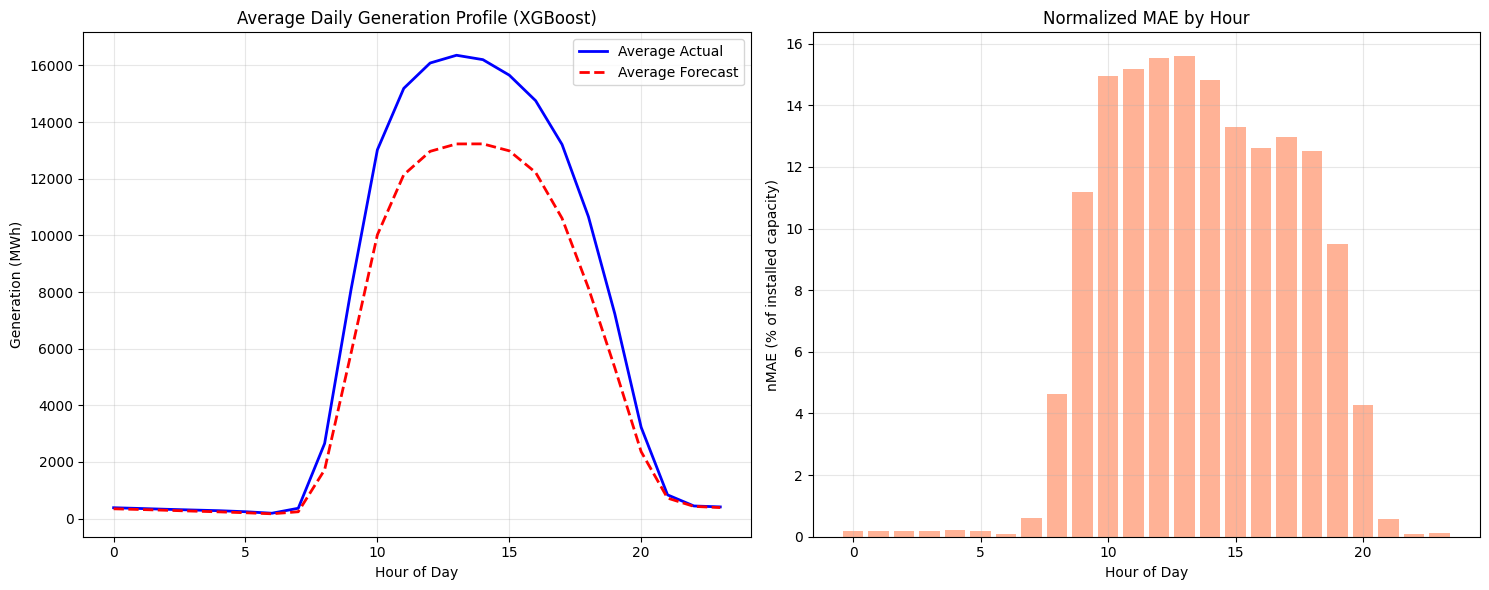

In [19]:
# Create hourly averages for error analysis
hourly_metrics = comparison.groupby('hour').agg({
    'generation': 'mean',
    'yhat': 'mean'
}).reset_index()

hourly_metrics['mae'] = abs(hourly_metrics['generation'] - hourly_metrics['yhat'])
hourly_metrics['nmae'] = hourly_metrics['mae'] / installed_capacity * 100

# Plot hourly performance
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(hourly_metrics['hour'], hourly_metrics['generation'], 'b-', label='Average Actual', linewidth=2)
plt.plot(hourly_metrics['hour'], hourly_metrics['yhat'], 'r--', label='Average Forecast', linewidth=2)
plt.title('Average Daily Generation Profile (XGBoost)')
plt.xlabel('Hour of Day')
plt.ylabel('Generation (MWh)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(hourly_metrics['hour'], hourly_metrics['nmae'], alpha=0.6, color='coral')
plt.title('Normalized MAE by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('nMAE (% of installed capacity)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

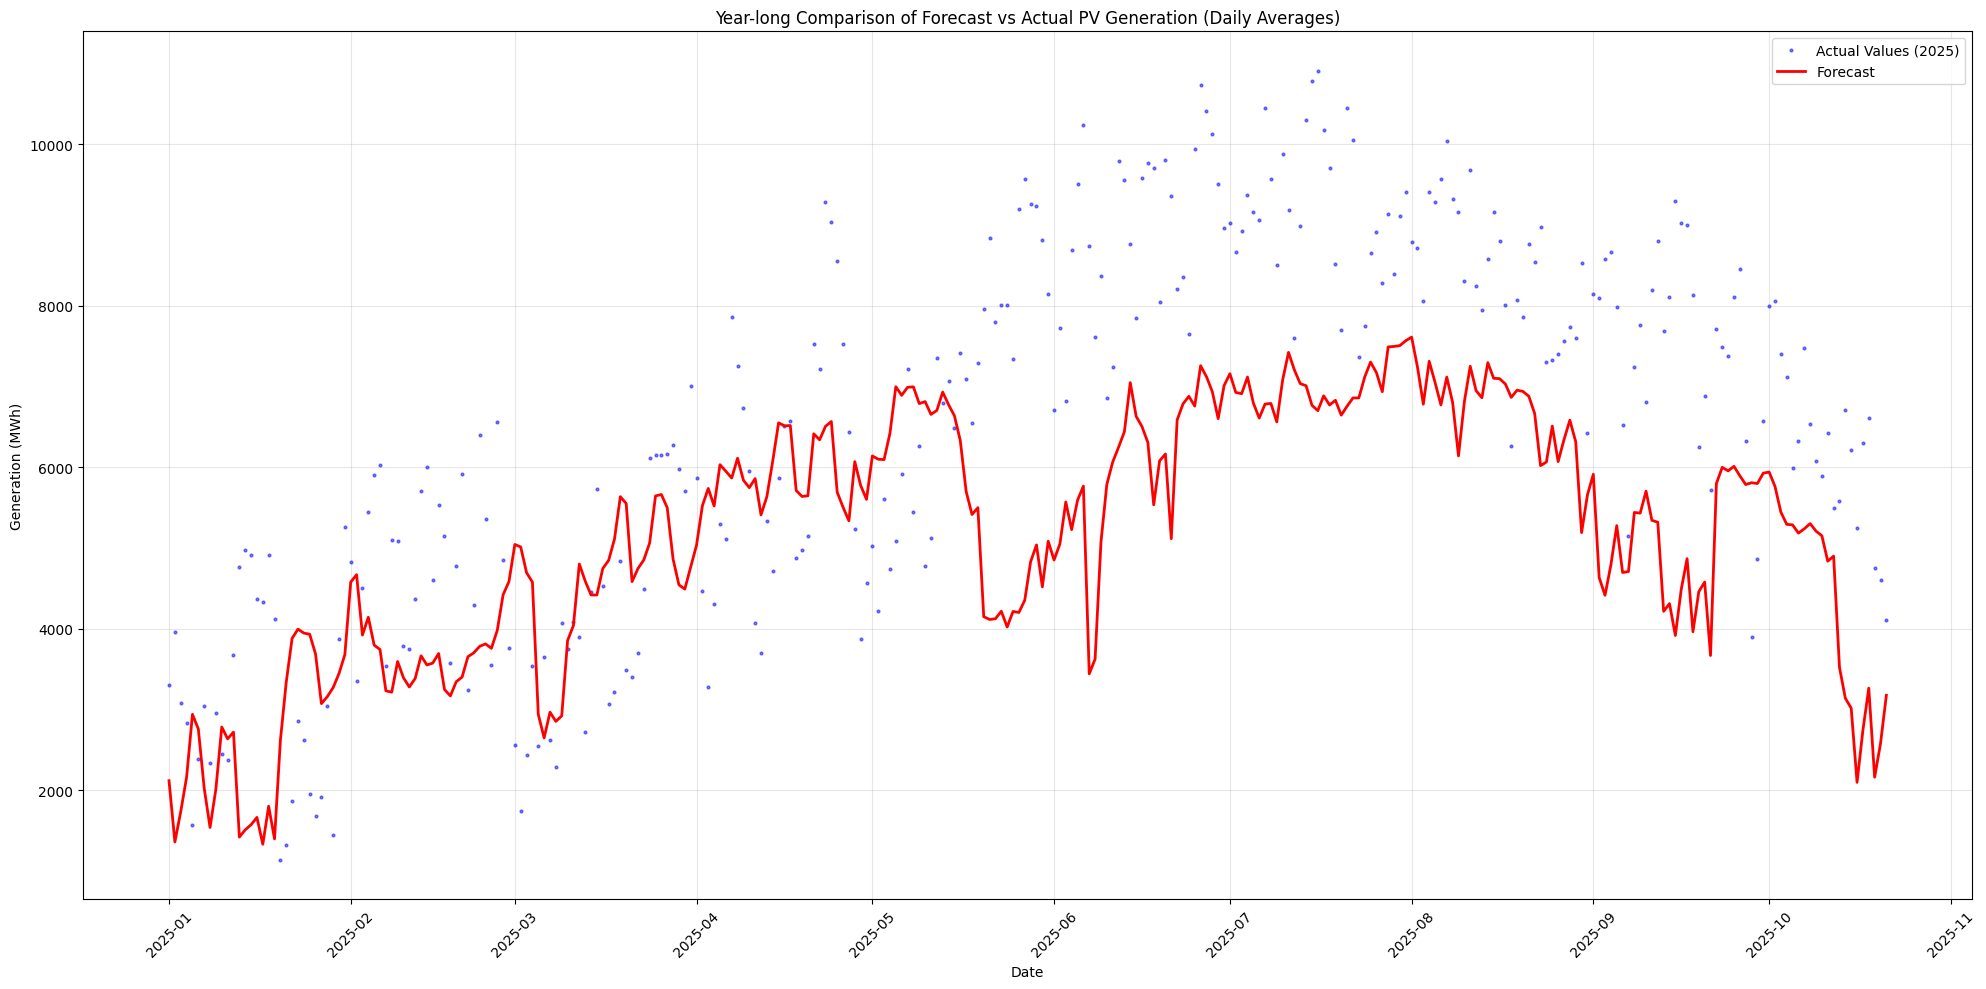


Monthly Performance Metrics:
January 2025:
  Average Actual: 3075.01 MWh
  Average Forecast: 2565.26 MWh
  MAE: 1656.75 MWh
  RMSE: 3266.87 MWh
  MAPE: 96.10%
  R²: 0.5228
  nRMSE: 16.27%
---------------------------
February 2025:
  Average Actual: 4820.84 MWh
  Average Forecast: 3724.86 MWh
  MAE: 1370.09 MWh
  RMSE: 2483.12 MWh
  MAPE: 61.34%
  R²: 0.8494
  nRMSE: 12.36%
---------------------------
March 2025:
  Average Actual: 4203.84 MWh
  Average Forecast: 4528.81 MWh
  MAE: 1351.04 MWh
  RMSE: 2355.58 MWh
  MAPE: 173.14%
  R²: 0.7964
  nRMSE: 11.73%
---------------------------
April 2025:
  Average Actual: 5906.32 MWh
  Average Forecast: 5891.51 MWh
  MAE: 1461.65 MWh
  RMSE: 2357.20 MWh
  MAPE: 136.33%
  R²: 0.8669
  nRMSE: 11.74%
---------------------------
May 2025:
  Average Actual: 7022.17 MWh
  Average Forecast: 5669.69 MWh
  MAE: 2349.78 MWh
  RMSE: 3755.39 MWh
  MAPE: 65.77%
  R²: 0.6885
  nRMSE: 18.70%
---------------------------
June 2025:
  Average Actual: 8821.97 MWh

In [20]:
# Plot comparison between forecast and actual values
plt.figure(figsize=(20, 10))

# Create daily averages for better visualization
daily_comparison = comparison.set_index('datetime').resample('D').mean().reset_index()

# Plot daily averages
plt.plot(daily_comparison['datetime'], daily_comparison['generation'], 'b.', label='Actual Values (2025)', alpha=0.5, markersize=4)
plt.plot(daily_comparison['datetime'], daily_comparison['yhat'], 'r-', label='Forecast', linewidth=2)

plt.title("Year-long Comparison of Forecast vs Actual PV Generation (Daily Averages)")
plt.xlabel("Date")
plt.ylabel("Generation (MWh)")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Add monthly statistics
from sklearn.metrics import r2_score

# Calculate R^2 and nRMSE for each month
print("\nMonthly Performance Metrics:")
print("===========================")

# Get unique months from the comparison data
comparison['year_month'] = comparison['datetime'].dt.to_period('M')
unique_months = comparison['year_month'].unique()

for month_period in unique_months:
    # Filter data for this specific month
    month_mask = comparison['year_month'] == month_period
    month_data = comparison[month_mask]
    
    # Skip months with insufficient data
    if len(month_data) < 2:
        print(f"{month_period.strftime('%B %Y')}: No data available")
        print("---------------------------")
        continue
    
    # Calculate metrics
    actual = month_data['generation'].values
    predicted = month_data['yhat'].values
    
    # Calculate MAE
    mae = mean_absolute_error(actual, predicted)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    # Calculate MAPE (excluding zero values)
    non_zero_mask = actual > 0
    if non_zero_mask.sum() > 0:
        mape = np.mean(np.abs((actual[non_zero_mask] - predicted[non_zero_mask]) / actual[non_zero_mask])) * 100
    else:
        mape = np.nan
    
    # Calculate R^2
    r2 = r2_score(actual, predicted)
    
    # Calculate nRMSE (normalized by installed capacity)
    nrmse = (rmse / installed_capacity) * 100
    
    print(f"{month_period.strftime('%B %Y')}:")
    print(f"  Average Actual: {actual.mean():.2f} MWh")
    print(f"  Average Forecast: {predicted.mean():.2f} MWh")
    print(f"  MAE: {mae:.2f} MWh")
    print(f"  RMSE: {rmse:.2f} MWh")
    if np.isnan(mape):
        print("  MAPE: N/A (zero values in actual data)")
    else:
        print(f"  MAPE: {mape:.2f}%")
    print(f"  R²: {r2:.4f}")
    print(f"  nRMSE: {nrmse:.2f}%")
    print("---------------------------")


In [21]:
# Export comparison data to CSV
export_data = comparison.copy()

# Convert datetime to string for better CSV readability
export_data['timestamp'] = export_data['datetime'].dt.strftime('%Y-%m-%d %H:%M')

# Select and rename columns for clarity
export_data = export_data[[
    'timestamp', 
    'hour',
    'generation', 
    'yhat'
]].rename(columns={
    'timestamp': 'Timestamp',
    'hour': 'Hour',
    'generation': 'Actual_Generation_MWh',
    'yhat': 'Forecast_Generation_MWh'
})

# Add error columns
export_data['Absolute_Error_MWh'] = abs(export_data['Actual_Generation_MWh'] - export_data['Forecast_Generation_MWh'])
export_data['Percentage_Error'] = np.where(
    export_data['Actual_Generation_MWh'] > 0,
    (export_data['Absolute_Error_MWh'] / export_data['Actual_Generation_MWh']) * 100,
    np.nan
)

# Export to CSV
output_path = 'pv_forecast_comparison_2025_xgboost.csv'
export_data.to_csv(output_path, index=False)
print(f"Data exported to: {output_path}")
print(f"Total records exported: {len(export_data)}")
print("\nFirst few rows of exported data:")
print(export_data.tail(24).to_string())

Data exported to: pv_forecast_comparison_2025_xgboost.csv
Total records exported: 7052

First few rows of exported data:
             Timestamp  Hour  Actual_Generation_MWh  Forecast_Generation_MWh  Absolute_Error_MWh  Percentage_Error
7028  2025-10-20 21:00    21             138.000000                92.837936           45.162064         32.726133
7029  2025-10-20 22:00    22              82.000000                76.738350            5.261650          6.416646
7030  2025-10-20 23:00    23              16.000000                66.611557           50.611557        316.322231
7031  2025-10-21 00:00     0              16.000000                45.158344           29.158344        182.239652
7032  2025-10-21 01:00     1              16.000000                39.182217           23.182217        144.888854
7033  2025-10-21 02:00     2              19.000000                37.461369           18.461369         97.165098
7034  2025-10-21 03:00     3              20.000000                36.1220

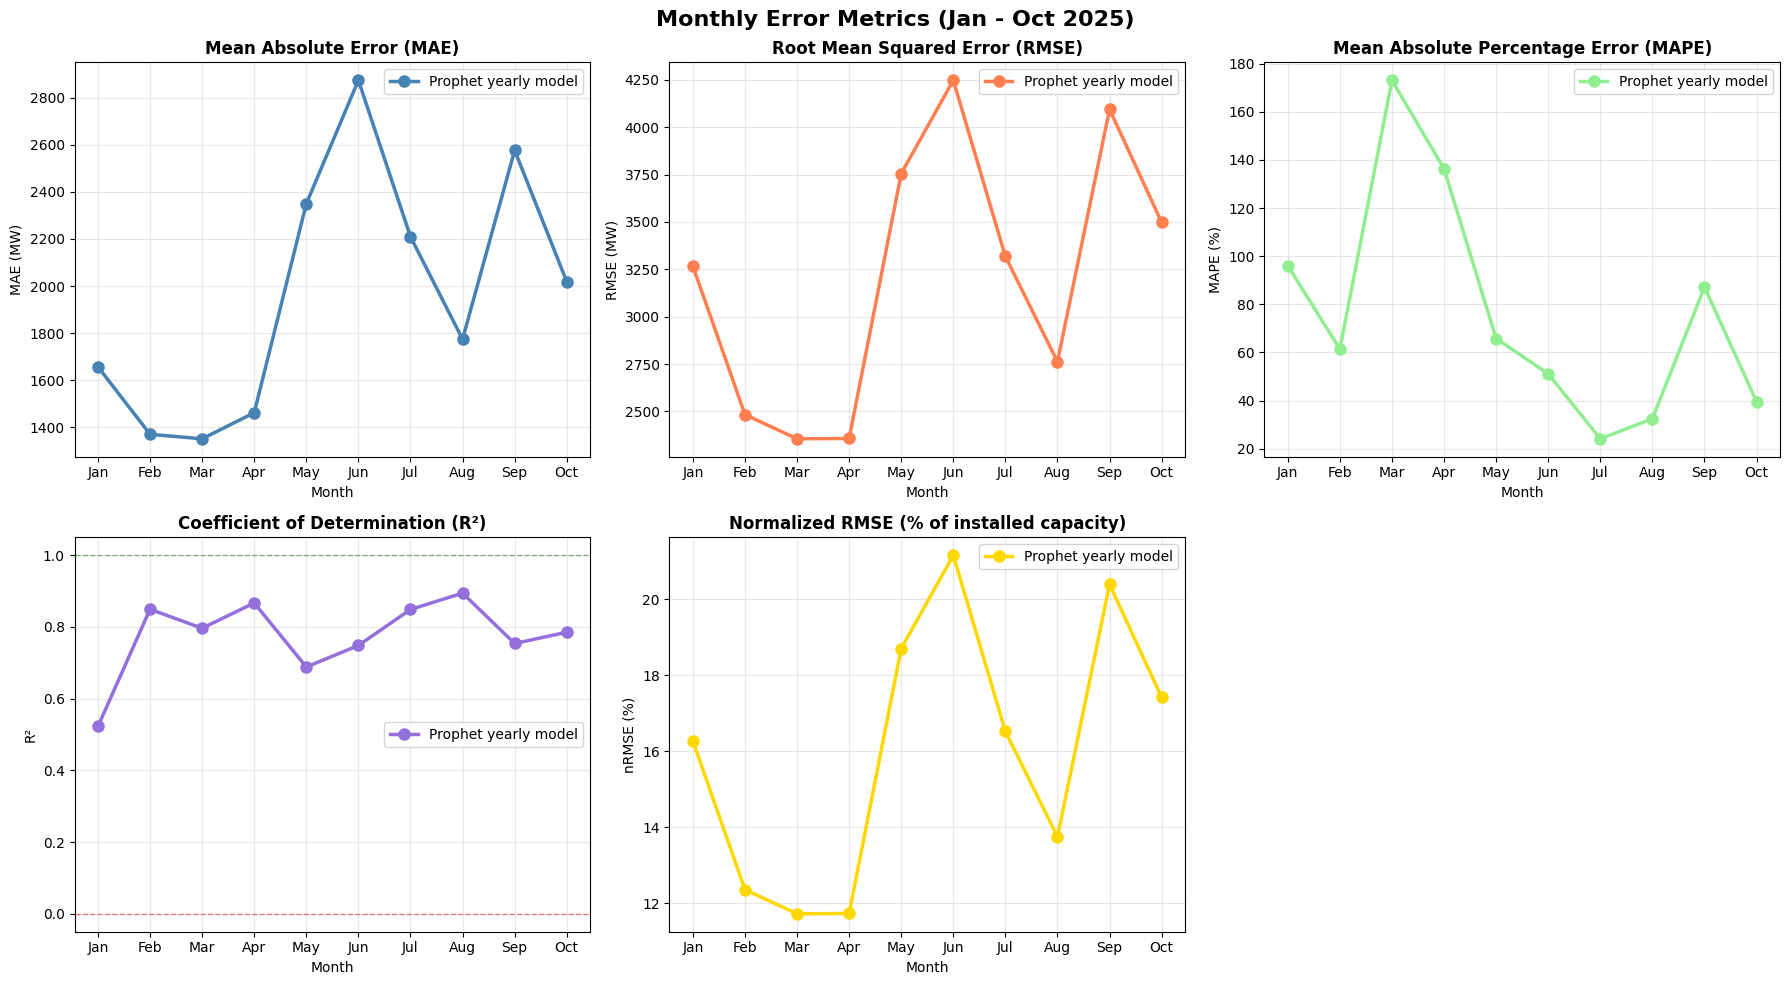


Overall Statistics:
  Best R² Month: Aug (0.8944)
  Worst R² Month: Jan (0.5228)
  Lowest MAE Month: Mar (1351.04 MW)
  Highest MAE Month: Jun (2874.41 MW)


In [22]:
# Create monthly error metrics visualization
from sklearn.metrics import r2_score

# Get unique months from the comparison data
comparison['year_month'] = comparison['datetime'].dt.to_period('M')
unique_months = sorted(comparison['year_month'].unique())

# Store metrics for each month
monthly_metrics_data = []

for month_period in unique_months:
    # Filter data for this specific month
    month_mask = comparison['year_month'] == month_period
    month_data = comparison[month_mask]
    
    # Skip months with insufficient data
    if len(month_data) < 2:
        continue
    
    # Calculate metrics
    actual = month_data['generation'].values
    predicted = month_data['yhat'].values
    
    # Calculate all metrics
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    # MAPE (excluding zero values)
    non_zero_mask = actual > 0
    if non_zero_mask.sum() > 0:
        mape = np.mean(np.abs((actual[non_zero_mask] - predicted[non_zero_mask]) / actual[non_zero_mask])) * 100
    else:
        mape = np.nan
    
    # R²
    r2 = r2_score(actual, predicted)
    
    # nRMSE (normalized by installed capacity)
    nrmse = (rmse / installed_capacity) * 100
    
    monthly_metrics_data.append({
        'Month': month_period.strftime('%b'),
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2,
        'nRMSE': nrmse
    })

# Create DataFrame for easier plotting
metrics_df = pd.DataFrame(monthly_metrics_data)

# Create subplots for each metric (2x3 layout, reduced to 5 plots)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Monthly Error Metrics (Jan - Oct 2025)', fontsize=16, fontweight='bold')

# Plot 1: MAE
ax1 = axes[0, 0]
ax1.plot(metrics_df['Month'], metrics_df['MAE'], marker='o', color='steelblue', 
         linewidth=2.5, markersize=8, label='Prophet yearly model')
ax1.set_title('Mean Absolute Error (MAE)', fontweight='bold')
ax1.set_ylabel('MAE (MW)')
ax1.set_xlabel('Month')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best')

# Plot 2: RMSE
ax2 = axes[0, 1]
ax2.plot(metrics_df['Month'], metrics_df['RMSE'], marker='o', color='coral', 
         linewidth=2.5, markersize=8, label='Prophet yearly model')
ax2.set_title('Root Mean Squared Error (RMSE)', fontweight='bold')
ax2.set_ylabel('RMSE (MW)')
ax2.set_xlabel('Month')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')

# Plot 3: MAPE
ax3 = axes[0, 2]
ax3.plot(metrics_df['Month'], metrics_df['MAPE'], marker='o', color='lightgreen', 
         linewidth=2.5, markersize=8, label='Prophet yearly model')
ax3.set_title('Mean Absolute Percentage Error (MAPE)', fontweight='bold')
ax3.set_ylabel('MAPE (%)')
ax3.set_xlabel('Month')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='best')

# Plot 4: R²
ax4 = axes[1, 0]
ax4.plot(metrics_df['Month'], metrics_df['R²'], marker='o', color='mediumpurple', 
         linewidth=2.5, markersize=8, label='Prophet yearly model')
ax4.set_title('Coefficient of Determination (R²)', fontweight='bold')
ax4.set_ylabel('R²')
ax4.set_xlabel('Month')
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
ax4.axhline(y=1, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax4.grid(True, alpha=0.3)
ax4.legend(loc='best')

# Plot 5: nRMSE
ax5 = axes[1, 1]
ax5.plot(metrics_df['Month'], metrics_df['nRMSE'], marker='o', color='gold', 
         linewidth=2.5, markersize=8, label='Prophet yearly model')
ax5.set_title('Normalized RMSE (% of installed capacity)', fontweight='bold')
ax5.set_ylabel('nRMSE (%)')
ax5.set_xlabel('Month')
ax5.grid(True, alpha=0.3)
ax5.legend(loc='best')

# Hide the unused subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Print summary table
#print("\nMonthly Error Metrics Summary Table:")
#print("=" * 80)
#print(metrics_df.to_string(index=False))
#print("=" * 80)
print(f"\nOverall Statistics:")
print(f"  Best R² Month: {metrics_df.loc[metrics_df['R²'].idxmax(), 'Month']} ({metrics_df['R²'].max():.4f})")
print(f"  Worst R² Month: {metrics_df.loc[metrics_df['R²'].idxmin(), 'Month']} ({metrics_df['R²'].min():.4f})")
print(f"  Lowest MAE Month: {metrics_df.loc[metrics_df['MAE'].idxmin(), 'Month']} ({metrics_df['MAE'].min():.2f} MW)")
print(f"  Highest MAE Month: {metrics_df.loc[metrics_df['MAE'].idxmax(), 'Month']} ({metrics_df['MAE'].max():.2f} MW)")


In [23]:
metrics_df.to_csv('xg_metrics_yearly.csv')
metrics_df

,Month,MAE,RMSE,MAPE,R²,nRMSE
0,Jan,1656.750231,3266.871297,96.100328,0.522765,16.267011
1,Feb,1370.092962,2483.121632,61.343345,0.849365,12.364419
2,Mar,1351.037997,2355.582447,173.139571,0.796412,11.729353
3,Apr,1461.651835,2357.200580,136.326604,0.866912,11.737410
4,May,2349.777272,3755.393413,65.770752,0.688469,18.699551
5,Jun,2874.412738,4247.625678,51.115211,0.748353,21.150565
6,Jul,2209.684915,3317.826515,24.102048,0.848807,16.520737
7,Aug,1773.972736,2762.389000,32.435791,0.894420,13.754999
8,Sep,2576.864388,4094.090016,87.154343,0.753908,20.386052
9,Oct,2018.956641,3497.958028,39.584852,0.785310,17.417681
